# Import libraries
* numpy for simple data manipulation
* pandas and geopandas for data analysis
* matplotlib to plotdata visually

In [49]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from fiona.crs import from_epsg
import os

In [152]:
pd.set_option("display.max_columns", 50)

# Input variables
#### Define arbitrary weights for this example

In [50]:
weights = pd.DataFrame({
  'Commercial': [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  'Administrative': [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
  'Residential': [1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1],
}, index=list(range(1, 24, 2))).T

weights.head()

,1,3,5,7,9,11,13,15,17,19,21,23
Commercial,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Administrative,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
Residential,1.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0


#### Define daytime and nighttime hours

In [51]:
day = ['7', '11', '13', '15', '17', '19', '21']
night = ['23', '1', '3', '5']

In [52]:
area = gpd.read_file('data/area.geojson').to_crs(epsg=3035)
buildings = gpd.read_file('data/buildings.geojson').to_crs(epsg=3035)
grid = gpd.read_file('data/grid.geojson').to_crs(epsg=3035)
mobileActivity = pd.read_csv('data/mobile_activity.csv', index_col=0).groupby(["hour"])

In [54]:
buildings['area'] = buildings['geometry'].area

buildingIDs = buildings['B_ID'].unique()

for ID in buildingIDs:
  l = len(buildings[buildings['B_ID'] == ID])
  buildings.loc[buildings['B_ID'] == ID, 'area'] /= l

In [56]:
buildings["floor_area"] = buildings["area"] * buildings["floors"]
buildings.head()

,B_ID,AREA_ID,aggregated_type,census_population,floors,geometry,area,floor_area
0,505639702,10014,Residential,12.0,6.0,"(POLYGON ((4801964.04852097 2919507.381313595,...",274.720231,1648.321389
1,505892702,10014,Residential,34.5,6.0,(POLYGON ((4801808.535110435 2919817.198085646...,504.501050,3027.006298
2,505729702,10014,Commercial,NaN,4.0,"(POLYGON ((4801793.09225574 2919808.870167085,...",157.026250,628.104999
3,505907702,10014,Residential,24.5,7.0,(POLYGON ((4801811.718258977 2919735.405286827...,154.118722,1078.831051
4,505693702,10014,Residential,7.5,4.0,(POLYGON ((4801774.751116849 2919850.972140913...,451.832403,1807.329614


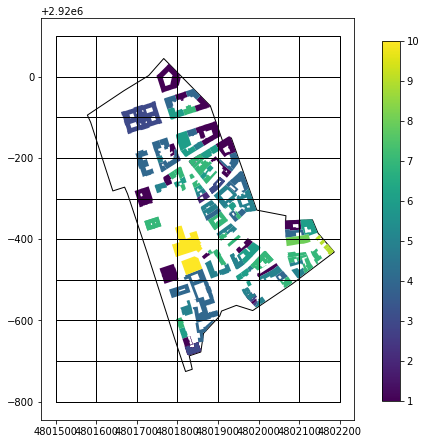

In [58]:
b = buildings.fillna(value=0)

fig, ax = plt.subplots(1, figsize=(7,10))
ax.set_aspect("equal")

area.plot(ax=ax, color='white', edgecolor='black')
b_ax = b.plot(ax=ax, column="floors", legend=True)
grid.plot(ax=ax, color='none', edgecolor='black')

fig.axes[1].set_position([0.8, 0.25, 0.8, 0.5])

In [60]:
print(f"Processing hour: {1}")
b = buildings.copy()
b["population_distribution_area"] = 0
mobileActivityPopulation = float(mobileActivity.get_group((1))["population"])
print(f"Census population: {mobileActivityPopulation}")

Processing hour: 1
Census population: 2679.4


In [62]:
def calculatePDA(row, hour):
    row["population_distribution_area"] = row["floor_area"] * (weights.loc[row["aggregated_type"], hour] / weights[hour].sum())
    return row

b = b.apply(calculatePDA, axis=1, hour=1)

totalDistributionArea = b["population_distribution_area"].sum()

b["effective_population"] = (b["population_distribution_area"] / totalDistributionArea) * mobileActivityPopulation

In [64]:
b = b.groupby("B_ID").agg({ "effective_population": np.sum })

results = {}
results["1"] = b

In [66]:
for hour in range(3, 24, 2):
    print(f"Processing hour: {hour}")
    b = buildings.copy()
    b["population_distribution_area"] = 0
    mobileActivityPopulation = float(mobileActivity.get_group((hour))["population"])
    print(f"Census population: {mobileActivityPopulation}")
    b = b.apply(calculatePDA, axis=1, hour=1)
    totalDistributionArea = b["population_distribution_area"].sum()
    b["effective_population"] = (b["population_distribution_area"] / totalDistributionArea) * mobileActivityPopulation
    b = b.groupby("B_ID").agg({ "effective_population": np.sum })
    results[str(hour)] = b

Processing hour: 3
Census population: 2598.0
Processing hour: 5
Census population: 2707.4
Processing hour: 7
Census population: 3855.8
Processing hour: 9
Census population: 4657.4
Processing hour: 11
Census population: 5130.8
Processing hour: 13
Census population: 5156.0
Processing hour: 15
Census population: 4945.0
Processing hour: 17
Census population: 4508.4
Processing hour: 19
Census population: 4037.4
Processing hour: 21
Census population: 3345.6
Processing hour: 23
Census population: 2725.4


In [67]:
buildingTypeHierarchy = ['Residential', 'Administrative', 'Commercial']

def mergeBuildingTypes(types):
    t = ""
    for bType in buildingTypeHierarchy:
        if bType in list(types):
            t = bType
            break
    return t

buildings = buildings.groupby("B_ID").agg({
    "AREA_ID": lambda x: list(x)[0],
    "geometry": lambda x: list(x)[0],
    "floors": np.mean,
    "area": np.sum,
    "census_population": np.sum,
    "aggregated_type": mergeBuildingTypes
})

In [88]:
buildings = gpd.GeoDataFrame(buildings, geometry='geometry')

In [91]:
for hour in results:
    buildings[hour] = results[hour]["effective_population"]

In [92]:
buildings["day"] = buildings[day].mean(axis=1)
buildings.loc[buildings["aggregated_type"] == "Residential", "day_diff"] = buildings["day"] * 100 / buildings["census_population"] - 100
buildings["night"] = buildings[night].mean(axis=1)
buildings.loc[buildings["aggregated_type"] == "Residential", "night_diff"] = buildings["night"] * 100 / buildings["census_population"] - 100
buildings = buildings.replace([np.inf, -np.inf], np.nan)

In [95]:
popCols = [str(i) for i in range(1, 24, 2)] + ["census_population", "day", "night"]
cols = [str(i) for i in range(1, 24, 2)] + ["area", "census_population", "day", "night", "relative_fragment_area"]

In [96]:
gbUnion = gpd.overlay(grid, buildings, how="union")

gbUnion["relative_fragment_area"] = gbUnion["geometry"].area / gbUnion["area"]

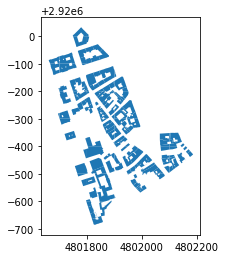

In [110]:
gbUnion.loc[gbUnion["relative_fragment_area"].notna()]

In [112]:
gbUnion[popCols] = gbUnion[popCols].multiply(gbUnion["relative_fragment_area"], axis="index")

In [115]:
colAgg = {**{k: np.sum for k in cols}, **{"day_diff": np.mean, "night_diff": np.mean}}

In [118]:
fragmentAttributes = gbUnion.groupby("OBJECTID").agg(colAgg)
popGrid = grid.merge(fragmentAttributes, left_on="OBJECTID", right_index=True)
popGrid

,OBJECTID,Join_Count,TARGET_FID,GRD_INSPIR,Shape_Leng,Shape_Area,geometry,1,3,5,...,19,21,23,area,census_population,day,night,relative_fragment_area,day_diff,night_diff
0,14856,1,14855,1kmN2919E4801,400.0,10000.0,(POLYGON ((4801500.000064867 2919299.999265373...,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN
1,15101,1,15100,1kmN2919E4802,400.0,10000.0,(POLYGON ((4802000.000064934 2919399.999265403...,52.878071,51.271638,53.430652,...,79.678257,66.025555,53.785883,2867.673541,1.211547e+01,87.338836,52.841561,2.230632,1140.520585,650.537179
2,15578,1,15577,1kmN2919E4801,400.0,10000.0,(POLYGON ((4801700.000064886 2919599.999265525...,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5510.464769,4.246120e-02,0.000000,0.000000,1.404761,NaN,NaN
3,15576,1,15575,1kmN2919E4801,400.0,10000.0,"(POLYGON ((4801500.000064857 2919599.99926554,...",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN
4,15102,1,15101,1kmN2919E4802,400.0,10000.0,(POLYGON ((4802100.000064948 2919399.999265401...,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN
5,14862,1,14861,1kmN2919E4802,400.0,10000.0,"(POLYGON ((4802100.00006495 2919299.999265344,...",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN
6,15100,1,15099,1kmN2919E4801,400.0,10000.0,(POLYGON ((4801900.000064921 2919399.999265403...,58.039846,56.276600,58.646369,...,87.456175,72.470743,59.036276,6591.910913,5.139803e+01,95.864554,57.999773,6.739841,1507.381883,872.494836
7,14861,1,14860,1kmN2919E4802,400.0,10000.0,(POLYGON ((4802000.000064936 2919299.999265355...,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN
8,15581,1,15580,1kmN2919E4802,400.0,10000.0,(POLYGON ((4802000.000064927 2919599.999265514...,32.109026,31.133555,32.444568,...,48.382839,40.092542,32.660274,2659.486756,1.528891e+00,53.034555,32.086856,1.845898,3618.891144,2149.995768
9,15099,1,15098,1kmN2919E4801,400.0,10000.0,(POLYGON ((4801800.000064906 2919399.999265416...,262.758177,254.775600,265.504026,...,395.931874,328.089780,267.269215,16604.083106,1.183544e+01,433.998313,262.576755,1.956072,7204.272560,4319.215758


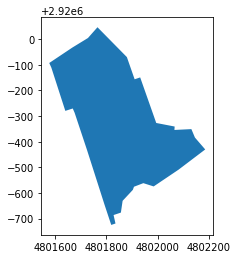

In [133]:
area.plot()

In [157]:
gbzUnion = gpd.overlay(grid, buildings, how="union")
gbzUnion = gpd.overlay(gbzUnion, area, how="union")

In [154]:
unionZoneAreas = gbzUnion[pd.notnull(gbzUnion["AREA_ID"])]

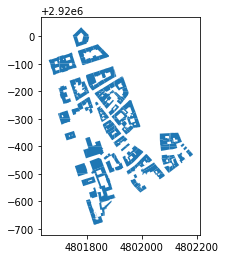

In [156]:
unionZoneAreas.plot()

In [146]:
unionZoneAreas = unionZoneAreas.loc[unionZoneAreas.aggregated_type.isna()]

In [119]:
unionZoneAreas["area"] = unionZoneAreas.geometry.area

In [140]:
transitData = pd.read_csv('data/mobile_activity.csv', index_col=0).drop(["population"], axis=1).set_index(["AREA_ID", "hour"]).unstack("hour")
transitData.columns = transitData.columns.droplevel(0)
transitData

hour,1,3,5,7,9,11,13,15,17,19,21,23
AREA_ID,,,,,,,,,,,,
10014,866.0,612.0,1442.15,4237.733333,3129.8,3819.2,4314.8,5065.2,4146.4,1907.6,861.4,1044.5


In [153]:
unionZoneAreas

,OBJECTID,Join_Count,TARGET_FID,GRD_INSPIR,Shape_Leng,Shape_Area,AREA_ID,floors,area,census_population,aggregated_type,1,3,5,7,9,11,13,15,17,19,21,23,day,day_diff,night,night_diff,AREA_ID_2,geometry
8,15580,1,15579,1kmN2919E4801,400.0,10000.0,10014.0,6.0,287.330983,0.0,Commercial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,10014.0,"POLYGON ((4801928.003466074 2919663.366661486,..."
11,15579,1,15578,1kmN2919E4801,400.0,10000.0,10014.0,5.0,525.385709,2.0,Residential,36.853808,35.734192,37.238934,53.034602,64.060210,70.571590,70.918204,68.016004,62.010789,55.532420,46.017056,37.486515,60.871524,2943.576188,36.828362,1741.418121,10014.0,"POLYGON ((4801871.824002887 2919665.498634078,..."
13,15578,1,15577,1kmN2919E4801,400.0,10000.0,10014.0,1.0,1469.617410,0.0,Administrative,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,10014.0,"POLYGON ((4801706.257889617 2919681.559956768,..."
14,15580,1,15579,1kmN2919E4801,400.0,10000.0,10014.0,4.0,481.619814,0.0,Commercial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,10014.0,"POLYGON ((4801908.190611061 2919669.389539503,..."
15,15580,1,15579,1kmN2919E4801,400.0,10000.0,10014.0,5.0,525.385709,2.0,Residential,36.853808,35.734192,37.238934,53.034602,64.060210,70.571590,70.918204,68.016004,62.010789,55.532420,46.017056,37.486515,60.871524,2943.576188,36.828362,1741.418121,10014.0,"POLYGON ((4801900.000064911 2919679.819347693,..."
17,15580,1,15579,1kmN2919E4801,400.0,10000.0,10014.0,5.0,1323.651208,24.5,Residential,92.849095,90.028346,93.819378,133.614817,161.392616,177.797320,178.670574,171.358803,156.229328,139.907792,115.934886,94.443131,153.359074,525.955405,92.784987,278.714234,10014.0,"POLYGON ((4801900.883486219 2919693.473467042,..."
18,15580,1,15579,1kmN2919E4801,400.0,10000.0,10014.0,5.0,1377.432386,0.0,Administrative,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,10014.0,"POLYGON ((4801978.326464973 2919667.912397834,..."
20,15580,1,15579,1kmN2919E4801,400.0,10000.0,10014.0,5.0,1377.432386,0.0,Administrative,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,"POLYGON ((4801994.452327099 2919672.984784122,..."
21,15579,1,15578,1kmN2919E4801,400.0,10000.0,10014.0,5.0,386.357303,12.0,Residential,27.101495,26.278153,27.384708,39.000501,47.108495,51.896823,52.151715,50.017500,45.601395,40.837342,33.839949,27.566774,44.763604,273.030032,27.082782,125.689852,10014.0,"POLYGON ((4801885.860946962 2919695.448718667,..."
22,15579,1,15578,1kmN2919E4801,400.0,10000.0,10014.0,5.0,1323.651208,24.5,Residential,92.849095,90.028346,93.819378,133.614817,161.392616,177.797320,178.670574,171.358803,156.229328,139.907792,115.934886,94.443131,153.359074,525.955405,92.784987,278.714234,10014.0,"POLYGON ((4801900.00006491 2919694.602265726, ..."


In [142]:
unionZoneAreas = unionZoneAreas[["AREA_ID", "area"]].groupby("AREA_ID").agg(sum)

In [144]:
unionZoneAreas

,area
AREA_ID,
10014.0,228417.779623


In [ ]:
def aggregateUnion(row):
    if pd.isna(row.aggregated_type) and pd.notna(row.AREA_ID):
        row["area"] = unionZoneAreas.loc[row.AREA_ID]
        for i in transitData.columns:
            row[str(i)] = row[i]
    return row

gbzUnion = gbzUnion.apply(aggregateUnion, axis=1)
gbzUnion

In [ ]:
gbzUnion = gbzUnion.drop(transitData.columns, axis=1)

gbzUnion["relative_fragment_area"] = gbzUnion["geometry"].area / gbzUnion["area"]
gbzUnion[[str(i) for i in range(start_h, end_h+1, 2)] + [populationField]] = gbzUnion[[str(i) for i in range(start_h, end_h+1, 2)] + [populationField]].multiply(gbzUnion["relative_fragment_area"], axis="index")

gbzUnion[cols] = gbzUnion[cols].astype(float)
gbzUnion["aggregated_type"] = gbzUnion["aggregated_type"].astype(str)

gbzUnion = prepareShape(input_df=gbzUnion, epsg_code=epsg)

fragmentAttributes = gbzUnion.groupby("OBJECTID").agg(sum)[cols]
# fragmentAttributes = gbzUnion.dissolve(
#   by=["OBJECTID"],
#   aggfunc='sum'
# ).reset_index()
popTransitGrid = grid.merge(fragmentAttributes, left_on="OBJECTID", right_index=True)